In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)
import math
from utils import *
import itertools



In [2]:
# Test with tau=0.9
nS = 8
nA = 2
seed = 3231
status_step = 500
gamma = 0.9
river = River(nS, gamma, 5, 1000)
tau = 0.3
xi = np.ones(river.nS)*1/river.nS
tmdp = TMDP(river, xi, tau, gamma, seed)
tmdp_0 = TMDP(river, xi, 0, gamma, seed)
tmdp_1 = TMDP(river, xi, 0.02, gamma, seed)

colors = itertools.cycle(["r", "b"])

In [3]:
# Optimal Q function
r_s_a = compute_r_s_a(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward)
Q_star = bellman_optimal_q(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward, 1e-4, gamma)
J_star = get_expected_avg_reward(tmdp.P_mat, get_policy(Q_star), tmdp.reward, tmdp.gamma, tmdp.mu)
delta_q = np.linalg.norm(Q_star - Q_star, np.inf)

## 1-step transfer learning test. From tau to original problem

In [4]:
taus = [0.2, 0.02]
results = []
intermediate_results = {}
curr_j = []
delta_qs = []
status_step = 200
tmdp_0 = TMDP(river, xi, 0, gamma)
models = {}
# Learning from scratch with different values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    Q = np.zeros((tmdp.nS, tmdp.nA))
    M = 300000
    
    s = tmdp.reset()
    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])
    
    Q, inner_main_J, inner_curr_J, inner_delta_qs, inner_delta_J, inner_l_bounds = Q_learning_3(tmdp, s, a, Q, Q_star, M=M, alpha=0.03, debug=True, status_step=status_step, main_p=False)
    
    intermediate_results['tau_'+str(tau)] = {'J_main_p': inner_main_J,"J_curr_p":inner_curr_J, "delta_q":inner_delta_qs, 'Q':Q, "tmdp":tmdp, "delta_J":inner_delta_J, "l_bounds": inner_l_bounds}
    delta_q = np.linalg.norm(Q_star - Q, np.inf)
    
    J = get_expected_avg_reward(tmdp.P_mat, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)
    results.append({"type":"scratch", "Q": Q, "tau":"{:.2f}".format(tau), "J":J, "policy":get_policy(Q),"delta_q":delta_q, "tmdp":tmdp})
    models[str(tau)] = {'Q':Q, 'tmdp':tmdp}
"""
    s = tmdp_0.reset()
    a = eps_greedy(s, Q, 1., tmdp_0.allowed_actions[s.item()])
    Q, inner_main_J, inner_curr_J, inner_delta_qs, _, _ = Q_learning(tmdp_0, s, a, Q, Q_star, M=M, alpha=0.03, debug=True, status_step=status_step)
    intermediate_results['transfer_'+str(tau)] = {'J_main_p': inner_main_J,"J_curr_p":inner_curr_J, "delta_q":inner_delta_qs, 'Q':Q, "tmdp":tmdp_0}
    delta_q = np.linalg.norm(Q_star - Q, np.inf)

    J = get_expected_avg_reward(tmdp_0.P_mat, get_policy(Q), tmdp_0.reward, tmdp_0.gamma, tmdp_0.mu)
    results.append({"type":"transfer", "Q": Q, "tau":"{:.2f}".format(tau), "J":J, "policy":get_policy(Q),"delta_q":delta_q, "tmdp":tmdp_0})"""

'\n    s = tmdp_0.reset()\n    a = eps_greedy(s, Q, 1., tmdp_0.allowed_actions[s.item()])\n    Q, inner_main_J, inner_curr_J, inner_delta_qs, _, _ = Q_learning(tmdp_0, s, a, Q, Q_star, M=M, alpha=0.03, debug=True, status_step=status_step)\n    intermediate_results[\'transfer_\'+str(tau)] = {\'J_main_p\': inner_main_J,"J_curr_p":inner_curr_J, "delta_q":inner_delta_qs, \'Q\':Q, "tmdp":tmdp_0}\n    delta_q = np.linalg.norm(Q_star - Q, np.inf)\n\n    J = get_expected_avg_reward(tmdp_0.P_mat, get_policy(Q), tmdp_0.reward, tmdp_0.gamma, tmdp_0.mu)\n    results.append({"type":"transfer", "Q": Q, "tau":"{:.2f}".format(tau), "J":J, "policy":get_policy(Q),"delta_q":delta_q, "tmdp":tmdp_0})'

In [5]:
agg_res = aggregate_results(results, len(results))

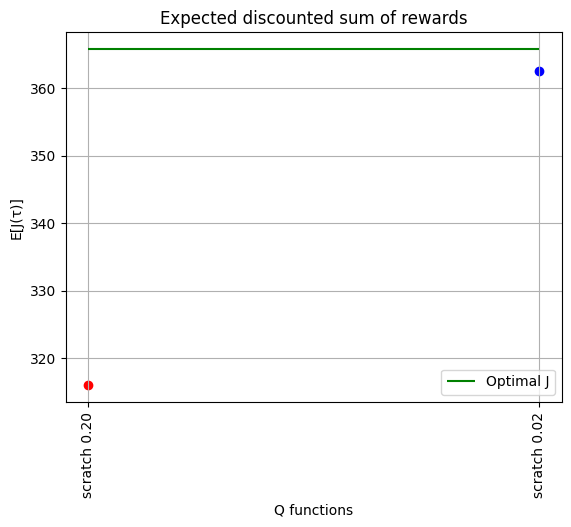

In [6]:
x = np.array([])
y = np.array([])
ci = np.array([])
for res in agg_res:
    yi =res['avg_J']
    y = np.append(y, yi)
    label = res['type'] + " " + str(res['tau'])
    x = np.append(x, label)
    ci = np.append(ci, res['ci_J'])
    plt.scatter(label, yi, c=next(colors))
x_map = np.array([i for i in range(len(x))])
offset = np.array([0.25 if ci[i] > 0.001 else 0 for i in range(len(x))])
#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')

plt.xticks(x_map, x)
#plt.plot(x, y)
#plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.hlines(y=y-ci, xmin=x_map-offset, xmax=x_map + offset)
plt.hlines(y=y+ci, xmin=x_map-offset, xmax=x_map + offset)
plt.hlines(y=J_star, xmin=0, xmax=len(x)-1, colors=['green'], label='Optimal J')
plt.vlines(x, ymin = y-ci, ymax = y+ci)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel("E[J(τ)]")
plt.title("Expected discounted sum of rewards")
plt.grid(visible=True)
plt.legend(loc="lower right")

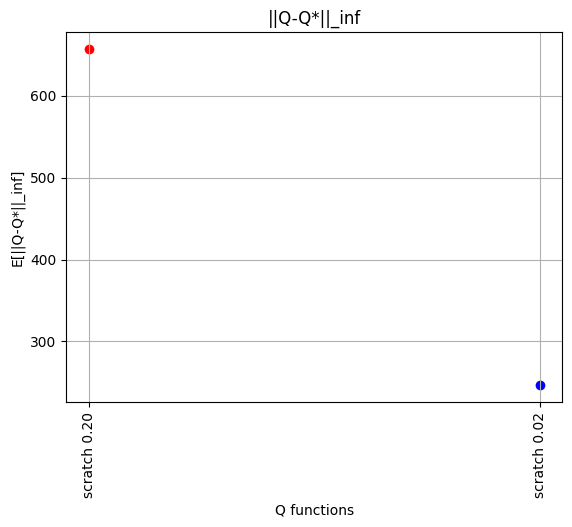

In [7]:
x = np.array([])
y = np.array([])
ci = np.array([])
for res in agg_res:
    yi = res['avg_delta_q']
    y = np.append(y, yi)
    label = res['type'] + " " + str(res['tau']) 
    x = np.append(x, label)
    ci = np.append(ci, res['ci_delta_q'])
    plt.scatter(label, yi, c=next(colors))
offset = np.array([0.25 if ci[i] > 0.001 else 0 for i in range(len(x))])
#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
#plt.scatter(x, y, c='orange')

plt.xticks(x_map, x)
#plt.plot(x, y)
#plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
plt.hlines(y=y-ci, xmin=x_map-offset, xmax=x_map + offset)
plt.hlines(y=y+ci, xmin=x_map-offset, xmax=x_map + offset)
plt.vlines(x, ymin = y-ci, ymax = y+ci)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel('E[||Q-Q*||_inf]')
plt.title("||Q-Q*||_inf")
plt.grid(visible=True)

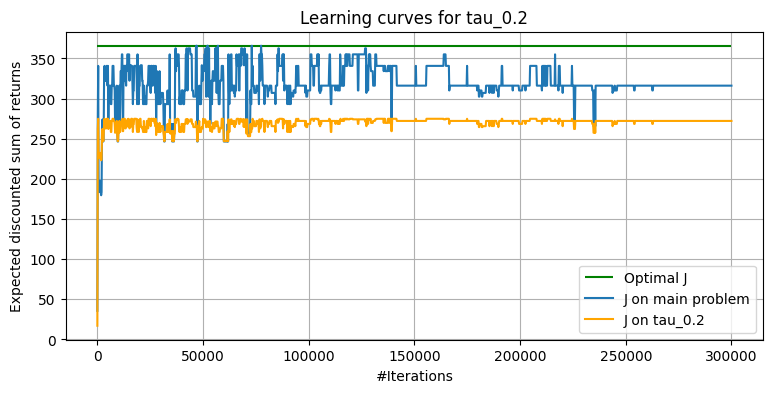

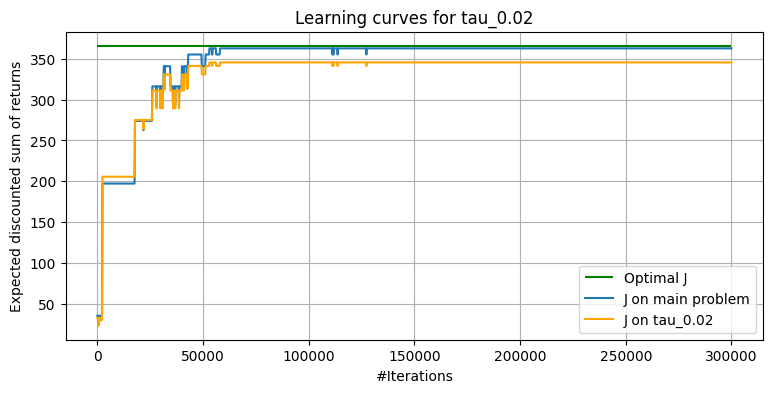

In [8]:
for i, key in enumerate(intermediate_results.keys()):
    xmax = len(intermediate_results[key]['J_main_p'])*status_step
    x = np.linspace(0, xmax, num=len(intermediate_results[key]['J_main_p']))
    y = intermediate_results[key]['J_main_p']
    z = intermediate_results[key]['J_curr_p']
    plt.figure(figsize=(9, 4))
    #plt.scatter(x, y, c='orange', label='Current J')
    plt.hlines(y=J_star, xmin=0, xmax=xmax, colors=['green'], label='Optimal J')
    if "tau_" in key:
        plt.plot(x, y, label='J on main problem')
        plt.plot(x, z, label='J on '+str(key), c='orange')
    else:
         plt.plot(x, y, label='J on '+str(key))
    plt.grid(visible=True)
    plt.legend(loc="lower right")
    plt.xlabel('#Iterations')
    plt.ylabel('Expected discounted sum of returns')
    plt.title('Learning curves for '+str(key))

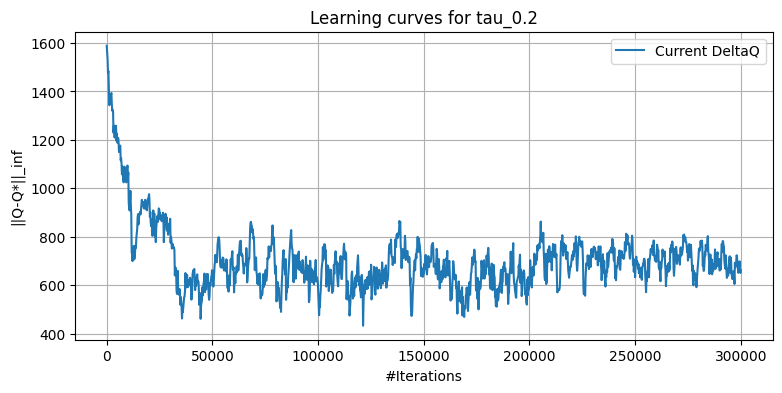

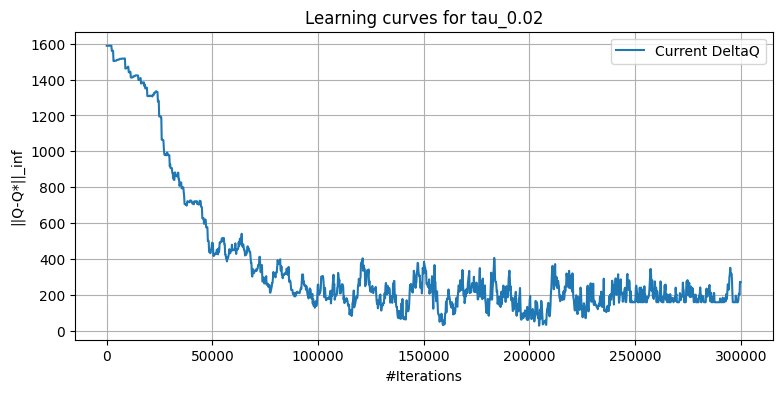

In [9]:
for i, key in enumerate(intermediate_results.keys()):
    xmax = len(intermediate_results[key]['delta_q'])*status_step
    x = np.linspace(0, xmax, num=len(intermediate_results[key]['delta_q']))
    y = intermediate_results[key]['delta_q']
    plt.figure(figsize=(9, 4))
    #plt.scatter(x, y, c='orange', label='Current DeltaQ')
    plt.plot(x, y, label='Current DeltaQ')
    plt.legend(loc="upper right")
    plt.xlabel('#Iterations')
    plt.ylabel('||Q-Q*||_inf')
    plt.grid(visible=True)
    plt.title('Learning curves for '+str(key))

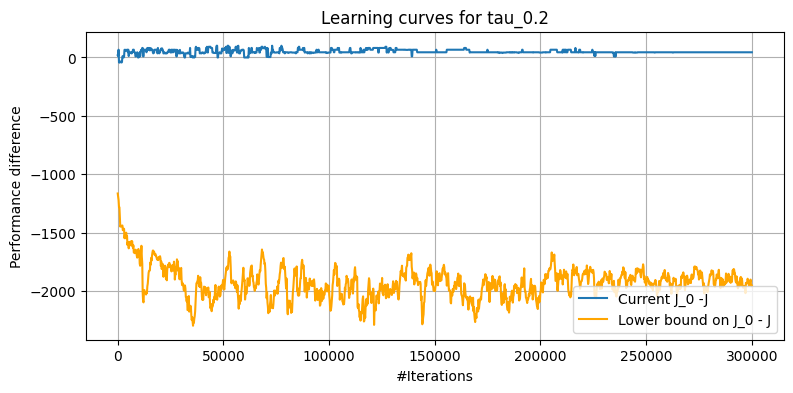

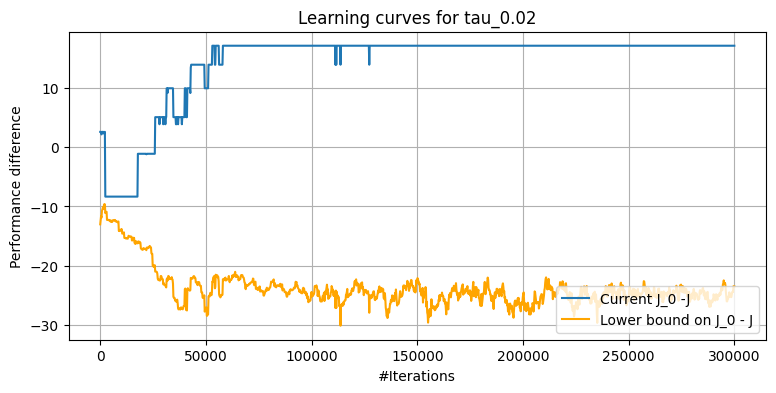

In [10]:
for i, key in enumerate(intermediate_results.keys()):
    if "tau_" in key:
        xmax = len(intermediate_results[key]['delta_J'])*status_step
        x = np.linspace(0, xmax, num=len(intermediate_results[key]['delta_J']))
        y = np.array(intermediate_results[key]['J_main_p']) - np.array(intermediate_results[key]['J_curr_p'])
        z = intermediate_results[key]['l_bounds']
        plt.figure(figsize=(9, 4))
        #plt.scatter(x, y, c='orange', label='Current J_0 -J')
        plt.plot(x, y, label='Current J_0 -J')

        #plt.scatter(x, z, c='blue', label='Lower bound on J_0 -J')
        plt.plot(x, z, c='orange', label='Lower bound on J_0 - J')

        plt.grid(visible=True)
        plt.legend(loc="lower right")
        plt.xlabel('#Iterations')
        plt.ylabel('Performance difference')
        plt.title('Learning curves for '+str(key))

In [11]:
print(get_expected_avg_reward(tmdp.P_mat, get_policy(Q_star), tmdp.reward, tmdp.gamma, tmdp.mu))

365.78861003317843


In [12]:
def build_Q(P_mat, reward, gamma, Q, det=True):
    nS, nA = Q.shape
    r_s_a = compute_r_s_a(nS, nA, P_mat, reward)
    V = get_value_function(Q, det)
    Q_test = np.zeros((nS, nA))
    
    for s in range(nS):
        for a in range(nA):
            Q_test[s,a] = r_s_a[s,a] + gamma * np.matmul(P_mat[s*nA +a], np.transpose(V))
            #print('Q({},{}) should be {}, whereas Q_build({},{}) is {}'.format(s, a, Q[s,a], s, a, Q_test[s,a]))
    return Q_test


In [13]:
def compute_relative_model_advantage_function_2(tau, tau_1, P_mat, xi, U):
    nS, nA, _ = U.shape
    A_tau_prime = np.zeros((nS, nA))
    for s in range(nS):
        for a in range(nA):
            for s1 in range(nS):
                A_tau_prime[s, a] = A_tau_prime[s,a] + (P_mat[s*nA +a][s1]-xi[s1])*U[s,a,s1]
            A_tau_prime[s, a] = A_tau_prime[s, a]*(tau-tau_1)
    return A_tau_prime


In [14]:
def compute_discounted_distribution_relative_model_advantage_function_hat(tau, tau_1, P_mat, xi, U, delta):
    expected_A = 0
    nS, nA, _ = U.shape
    for s in range(nS):
        for a in range(nA):
            sum_sprime = 0
            for s_prime in range(nS):
                sum_sprime = sum_sprime + (P_mat[s*nA + a, s_prime] - xi[s])* U[s, a, s_prime]
            expected_A = expected_A + sum_sprime*delta[s, a]
    return expected_A

In [15]:
i = 1
for key in models.keys():
    if i == 0:
        tmdp = models[key]['tmdp']
        Q = models[key]['Q']
        d = compute_d(tmdp.mu, tmdp.P_mat_tau, get_policy(Q), tmdp.gamma)

        delta = compute_delta(d, get_policy(Q))

        V = get_value_function(Q) 
        r_s_a = compute_r_s_a(nS, nA, tmdp.P_mat_tau, tmdp.reward)

        U = compute_state_action_nextstate_value_function(nS, nA, r_s_a, tmdp.gamma, V)
        J = get_expected_avg_reward(tmdp.P_mat_tau, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)
        
        Q_t = rebuild_Q_from_U(tmdp.P_mat_tau, U)

        A_s_a = compute_policy_advantage_function(nS, nA, Q, V)
        A_s_a_s1 = compute_model_advantage_function(U, Q)
        A_pi_pi1 = compute_relative_policy_advantage_function(get_policy(Q_star), A_s_a)
        
        A_tau_tau1 = compute_relative_model_advantage_function(tmdp.P_mat, A_s_a_s1)
        A_tau_tau2 = compute_relative_model_advantage_function_2(tmdp.tau, 0, tmdp.P_mat, tmdp.xi, U)

        A = compute_discounted_distribution_relative_model_advantage_function(A_tau_tau1, delta)
        A_2 = compute_discounted_distribution_relative_model_advantage_function(A_tau_tau2, delta)
        
        print(A)
        #print(A_2)

        A_hat = compute_discounted_distribution_relative_model_advantage_function_hat(tmdp.tau, 0, tmdp.P_mat, tmdp.xi, U, delta)
        #print(A_hat*(tmdp.tau-0))

        de = get_expected_difference_transition_models(tmdp.P_mat_tau, tmdp.P_mat)
        print(de, 2*tmdp.tau)
        d_inf = get_sup_difference_transition_models(tmdp.P_mat_tau, tmdp.P_mat)
        print(d_inf)
        d_d = get_difference_transition_models(tmdp.P_mat_tau, tmdp.P_mat, tmdp.gamma)
        print(d_d, 4*gamma*tmdp.tau**2)

        d_q_t = get_sup_difference_q(Q_t)
        d_q = get_sup_difference_q(Q)
        #print(d_q_t)
        print(d_q)

        print(compute_performance_improvement_lower_bound(A_2, gamma, d_q_t, d_d))
        #print(compute_performance_improvement_lower_bound(A_2, gamma, d_q_t, d_d))
        print(A_2/(1-gamma))
        print(A_2/(1-gamma)-gamma*d_q_t*d_d/(2*(1-gamma)**2))
    i=0

4.386965183435703
0.03100000000000008 0.04
0.03500000000000007
0.0009765000000000045 0.00144
747.4271070649435
-23.860388180110338
10.804642991833024
-23.860388180110338
